# Treatment of Missing Values in Time Series

(Sourced from: https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

Sometimes, your time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero.

Secondly, when it comes to time series, you should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What you could do instead for a quick and dirty workaround is to forward-fill the previous value.

However, depending on the nature of the series, you want to try out multiple approaches before concluding. Some effective alternatives to imputation are:

- Backward fill
- linear interpolation
- quadratic interpolation
- mean of nearest neighbors
- mean of seasonal counterparts

To measure the imputation performance, manually introduce missing values to the time series, impute it with above approaches and then measure the mean squared error of the imputed against the actual values.

Interpolation References:

https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html

https://docs.scipy.org/doc/scipy/reference/interpolate.html

You could also consider the following approaches depending on how accurate you want the imputations to be.

- If you have explanatory variables use a prediction model like the random forest or k-Nearest Neighbors to predict it.
- If you have enough past observations, forecast the missing values.
- If you have enough future observations, backcast the missing values
- Forecast of counterparts from previous cycles.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
# load / generate data
url = "https://raw.githubusercontent.com/selva86/datasets/master/a10.csv"
df_original = pd.read_csv(url, parse_dates=["date"], index_col="date").head(100)

url2 = "https://raw.githubusercontent.com/selva86/datasets/master/a10_missings.csv"
df_missing = pd.read_csv(url2, parse_dates=["date"], index_col="date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice


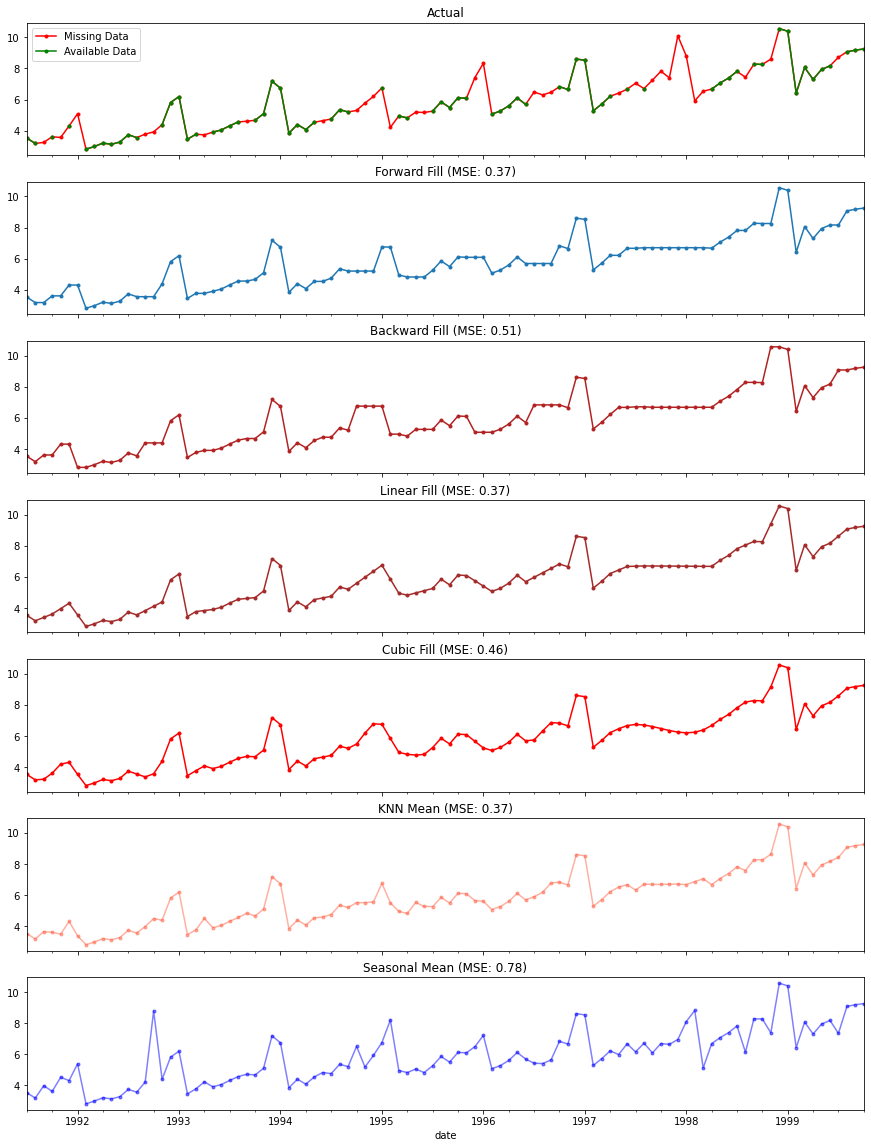

In [3]:
# plot datasets
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 20), sharex=True)

# 1. Actual
df_original.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df_missing.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

# 2. Forward Fill
df_ffill = df_missing.ffill()
error = np.round(mean_squared_error(df_original['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

# 3. Backward Fill
df_bfill = df_missing.bfill()
error = np.round(mean_squared_error(df_original['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

# 4. Linear Interpolation
df_missing['rownum'] = np.arange(df_missing.shape[0]) # get all x values
df_nona = df_missing.dropna(subset = ['value']) # get all missing y values
f = interp1d(df_nona['rownum'], df_nona['value']) # create function to fill other df at missing x and y values 
df_missing['linear_fill'] = f(df_missing['rownum']) # apply that function to the df to fill missing values
error = np.round(mean_squared_error(df_original['value'], df_missing['linear_fill']), 2)
df_missing['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

# 5. Cubic Interpolation
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df_missing['cubic_fill'] = f2(df_missing['rownum'])
error = np.round(mean_squared_error(df_original['value'], df_missing['cubic_fill']), 2)
df_missing['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# 6. Mean of 'n' Nearest Past Neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df_missing['knn_mean'] = knn_mean(df_missing["value"].values, 8)
error = np.round(mean_squared_error(df_original['value'], df_missing['knn_mean']), 2)
df_missing['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

# 7. Seasonal Mean
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df_missing['seasonal_mean'] = seasonal_mean(df_missing["value"], n=12, lr=1.25)
error = np.round(mean_squared_error(df_original['value'], df_missing['seasonal_mean']), 2)
df_missing['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

# show all
plt.show()